# IMPORTS

In [ ]:
import tensorflow as tf # For Creating Neural Networks and working with tensors
import numpy as np # Mathemtical computation of numpy arrays
import matplotlib.pyplot as plt # For plotting charts and insights, visualizing data
import xml.etree.ElementTree as ET # For parsing xml file (images annotations are in xml file format)
import os # For listing directories or navigating over directories and creating tastks
import shutil # For moving files
import cv2 # Computer vision libray for working with images
import random # For randomness
import albumentations as A # A good library for image augmentation
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape, LeakyReLU) # For layers need in our model
from tensorflow.keras.optimizers import Adam # Will be using adam optimizer
from tensorflow.keras.callbacks import (Callback, LearningRateScheduler, ModelCheckpoint) # For callbacks to do things while model is training

# Connecting Google Drive for downloading my kaggle json file

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/kaggle.json" "/content/kaggle.json"

# Dataset Download

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d huanghanchina/pascal-voc-2012

100% 3.62G/3.63G [00:48<00:00, 139MB/s]
100% 3.63G/3.63G [00:48<00:00, 80.3MB/s]


In [ ]:
!unzip "/content/pascal-voc-2012.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/voc2012/VOC2012/SegmentationClass/2008_001829.png  
  inflating: /content/dataset/voc2012/VOC2012/SegmentationClass/2008_001874.png  
  inflating: /content/dataset/voc2012/VOC2012/SegmentationClass/2008_001876.png  
  inflating: /content/dataset/voc2012/VOC2012/SegmentationClass/2008_001882.png  
  inflating: /content/dataset/voc2012/VOC2012/SegmentationClass/2008_001885.png  
  inflating: /content/dataset/voc2012/VOC2012/SegmentationClass/2008_001895.png  
  inflating: /content/dataset/voc2012/VOC2012/SegmentationClass/2008_001896.png  
  inflating: /content/dataset/voc2012/VOC2012/SegmentationClass/2008_001926.png  
  inflating: /content/dataset/voc2012/VOC2012/SegmentationClass/2008_001966.png  
  inflating: /content/dataset/voc2012/VOC2012/SegmentationClass/2008_001971.png  
  inflating: /content/dataset/voc2012/VOC2012/SegmentationClass/2008_001992.png  
  inflating: /content/dataset/voc2012/VOC2012/S

# Defining Paths & Configuration

In [ ]:
train_images='/content/dataset/VOC2012/JPEGImages/'
train_maps='/content/dataset/VOC2012/Annotations/'

val_images='/content/dataset/VOC2012/ValJPEGImages/'
val_maps='/content/dataset/VOC2012/ValAnnotations/'

classes=['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable',
         'dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']

B=2
N_CLASSES=len(classes)
H,W =224,224
SPLIT_SIZE=H//32
N_EPOCHS=135
BATCH_SIZE=32

In [ ]:
!mkdir /content/dataset/VOC2012/ValJPEGImages/
!mkdir /content/dataset/VOC2012/ValAnnotations/

In [ ]:
files = os.listdir(train_images)
val_list = random.sample(files, 64)

In [ ]:
for name in val_list:
  shutil.move(train_maps+name[:-3]+"xml", val_maps+name[:-3]+"xml")

In [ ]:
for name in val_list:
  shutil.move(train_images+name, val_images+name)

# Data Preparation And Augmentation

In [ ]:
im_paths=[]
xml_paths=[]

val_im_paths=[]
val_xml_paths=[]


for i in os.listdir(train_maps):
  im_paths.append(train_images+i[:-3]+'jpg')
  xml_paths.append(train_maps+i)

for i in os.listdir(val_maps):
  val_im_paths.append(val_images+i[:-3]+'jpg')
  val_xml_paths.append(val_maps+i)

FileNotFoundError: ignored

In [ ]:
train_dataset=tf.data.Dataset.from_tensor_slices((im_paths,xml_paths))
val_dataset=tf.data.Dataset.from_tensor_slices((val_im_paths,val_xml_paths))

In [ ]:
def preprocess_xml(filename):
  tree = ET.parse(filename)
  root = tree.getroot()
  size_tree = root.find('size')
  height = float(size_tree.find('height').text)
  width = float(size_tree.find('width').text)
  bounding_boxes=[]
  for object_tree in root.findall('object'):
    for bounding_box in object_tree.iter('bndbox'):
      xmin = (float(bounding_box.find('xmin').text))
      ymin = (float(bounding_box.find('ymin').text))
      xmax = (float(bounding_box.find('xmax').text))
      ymax = (float(bounding_box.find('ymax').text))
      break
    class_name = object_tree.find('name').text
    class_dict={classes[i]:i for i in range(len(classes))}
    bounding_box = [
        (xmin+xmax)/(2*width),(ymin+ymax)/(2*height),(xmax-xmin)/width,
        (ymax-ymin)/height,class_dict[class_name]]
    bounding_boxes.append(bounding_box)
  return tf.convert_to_tensor(bounding_boxes)

In [ ]:
def generate_output(bounding_boxes):
  output_label=np.zeros((SPLIT_SIZE,SPLIT_SIZE,N_CLASSES+5))
  for b in range(len(bounding_boxes)):
    grid_x=bounding_boxes[...,b,0]*SPLIT_SIZE
    grid_y=bounding_boxes[...,b,1]*SPLIT_SIZE
    i=int(grid_x)
    j=int(grid_y)

    output_label[i,j,0:5]=[1.,grid_x%1,grid_y%1,bounding_boxes[...,b,2],bounding_boxes[...,b,3]]
    output_label[i,j,5+int(bounding_boxes[...,b,4])]=1.

  return tf.convert_to_tensor(output_label,tf.float32)

In [ ]:
def get_imbboxes(im_path,xml_path):
  img=tf.io.decode_jpeg(tf.io.read_file(im_path))
  img=tf.cast(tf.image.resize(img, [H,W]),dtype=tf.float32)

  bboxes=tf.numpy_function(func=preprocess_xml, inp=[xml_path], Tout=tf.float32)
  return img,bboxes

In [ ]:
train_dataset=train_dataset.map(get_imbboxes)
val_dataset=val_dataset.map(get_imbboxes)

In [ ]:
transforms = A.Compose([
    A.Resize(H,W),
    A.RandomCrop(
         width=np.random.randint(int(0.9*W),W),
         height=np.random.randint(int(0.9*H),H), p=0.5),
    A.RandomScale(scale_limit=0.1, interpolation=cv2.INTER_LANCZOS4,p=0.5),
    A.HorizontalFlip(p=0.5,),
    A.Resize(H,W),

], bbox_params=A.BboxParams(format='yolo', ))

In [ ]:
def aug_albument(image,bboxes):
  augmented=transforms(image=image,bboxes=bboxes)
  return [tf.convert_to_tensor(augmented["image"],dtype=tf.float32),
          tf.convert_to_tensor(augmented["bboxes"],dtype=tf.float32)]

In [ ]:
def process_data(image,bboxes):
    aug= tf.numpy_function(func=aug_albument, inp=[image,bboxes], Tout=(tf.float32,tf.float32))
    return aug[0],aug[1]

In [ ]:
train_dataset=train_dataset.map(process_data)

In [ ]:
def preprocess_augment(img,y):
  img = tf.image.random_brightness(img, max_delta=50.)
  img = tf.image.random_saturation(img, lower=0.5, upper=1.5)
  img = tf.image.random_contrast(img, lower=0.5, upper=1.5)
  img = tf.clip_by_value(img, 0, 255)
  labels=tf.numpy_function(func=generate_output, inp=[y], Tout=(tf.float32))
  return img,labels

In [ ]:
def preprocess(img,y):
  img = tf.cast(tf.image.resize(img, size=[H, W]), dtype=tf.float32)

  labels=tf.numpy_function(func=generate_output, inp=[y], Tout=(tf.float32))
  return img,labels

In [ ]:
train_dataset=train_dataset.map(preprocess_augment)
val_dataset=val_dataset.map(preprocess)

In [ ]:
train_dataset=(
  train_dataset.
  batch(BATCH_SIZE).
  prefetch(tf.data.AUTOTUNE)
)

In [ ]:
val_dataset=(
  val_dataset.
  batch(BATCH_SIZE).
  prefetch(tf.data.AUTOTUNE)
)

# Model

In [ ]:
NUM_FILTERS=512
OUTPUT_DIM=N_CLASSES+5*B

In [ ]:
#base_model = tf.keras.applications.resnet50.ResNet50(
base_model=tf.keras.applications.efficientnet.EfficientNetB1(
    weights='imagenet',
    input_shape=(H,W,3),
    include_top=False,
)
base_model.trainable=False

In [ ]:
model=tf.keras.Sequential([
  base_model,
  Conv2D(NUM_FILTERS,(3,3), padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  LeakyReLU(alpha=0.1),

  Flatten(),

  Dense(NUM_FILTERS,kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Dropout(0.5),

  Dense(SPLIT_SIZE*SPLIT_SIZE*OUTPUT_DIM,activation='sigmoid'),

  Reshape((SPLIT_SIZE,SPLIT_SIZE,OUTPUT_DIM)),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 7, 7, 1280)       6575239   
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 512)         5898752   
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 7, 7, 512)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 512)         2359808   
                                                                 
 batch_normalization_5 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                        

# YOLO LOSS

In [ ]:
def compute_iou(boxes1, boxes2):
    boxes1_t = tf.stack([boxes1[..., 0] - boxes1[..., 2] / 2.0,
                         boxes1[..., 1] - boxes1[..., 3] / 2.0,
                         boxes1[..., 0] + boxes1[..., 2] / 2.0,
                         boxes1[..., 1] + boxes1[..., 3] / 2.0],
                        axis=-1)

    boxes2_t = tf.stack([boxes2[..., 0] - boxes2[..., 2] / 2.0,
                         boxes2[..., 1] - boxes2[..., 3] / 2.0,
                         boxes2[..., 0] + boxes2[..., 2] / 2.0,
                         boxes2[..., 1] + boxes2[..., 3] / 2.0],
                        axis=-1)
    lu = tf.maximum(boxes1_t[..., :2], boxes2_t[..., :2])
    rd = tf.minimum(boxes1_t[..., 2:], boxes2_t[..., 2:])

    intersection = tf.maximum(0.0, rd - lu)
    inter_square = intersection[..., 0] * intersection[..., 1]

    square1 = boxes1[..., 2] * boxes1[..., 3]
    square2 = boxes2[..., 2] * boxes2[..., 3]

    union_square = tf.maximum(square1 + square2 - inter_square, 1e-10)
    return tf.clip_by_value(inter_square / union_square, 0.0, 1.0)

In [ ]:
def difference(x,y):
  return tf.reduce_sum(tf.square(y-x))

In [ ]:
def yolo_loss(y_true, y_pred):
  target = y_true[...,0]

  ###################### OBject Loss
  y_pred_extract = tf.gather_nd(y_pred, tf.where(target[:]==1))
  y_target_extract = tf.gather_nd(y_true, tf.where(target[:]==1))

  rescaler = tf.where(target[:]==1)*SPLIT_SIZE
  upscaler_1 = tf.concat([rescaler[:,1:],tf.zeros([len(rescaler),2], dtype=tf.int64)],axis=-1)

  target_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                       repeats=[len(rescaler)], axis=0)*tf.cast(y_target_extract[...,1:5], dtype = tf.float32)
  pred_1_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                      repeats=[len(rescaler)], axis=0)*tf.cast(y_pred_extract[...,1:5], dtype = tf.float32)
  pred_2_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                      repeats=[len(rescaler)], axis=0)*tf.cast(y_pred_extract[...,6:10], dtype = tf.float32)

  target_orig = tf.cast(upscaler_1, dtype = tf.float32)+target_upscaler_2
  pred_1_orig = tf.cast(upscaler_1, dtype = tf.float32)+pred_1_upscaler_2
  pred_2_orig = tf.cast(upscaler_1, dtype = tf.float32)+pred_2_upscaler_2

  mask =tf.cast(tf.math.greater(compute_iou(target_orig,pred_2_orig),
                                         compute_iou(target_orig,pred_1_orig)),dtype=tf.int32)

  y_pred_joined=tf.transpose(tf.concat([tf.expand_dims(y_pred_extract[...,0],axis=0),
                        tf.expand_dims(y_pred_extract[...,5],axis=0)],axis=0))

  obj_pred = tf.gather_nd(y_pred_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1))

  object_loss = difference(tf.cast(obj_pred,dtype =tf.float32)
                            ,tf.cast(tf.ones([len(rescaler)]),dtype=tf.float32))

  ####################### For No object
  y_pred_extract = tf.gather_nd(y_pred[...,0:B*5], tf.where(target[:]==0))
  y_target_extract = tf.zeros(len(y_pred_extract))

  no_object_loss_1 = difference(tf.cast(y_pred_extract[...,0],dtype =tf.float32)
                            ,tf.cast(y_target_extract,dtype=tf.float32))

  no_object_loss_2 = difference(tf.cast(y_pred_extract[...,5],dtype =tf.float32)
                            ,tf.cast(y_target_extract,dtype=tf.float32))

  no_object_loss = no_object_loss_1+no_object_loss_2

  ######################## For OBject class loss
  y_pred_extract = tf.gather_nd(y_pred[...,10:],tf.where(target[:]==1))
  class_extract = tf.gather_nd(y_true[...,5:],tf.where(target[:]==1))

  class_loss = difference(tf.cast(y_pred_extract,dtype =tf.float32)
                                ,tf.cast(class_extract,dtype=tf.float32))

  ######################### For object bounding box loss
  y_pred_extract = tf.gather_nd(y_pred[...,0:B*5], tf.where(target[:]==1))
  centre_joined=tf.stack([y_pred_extract[...,1:3],y_pred_extract[...,6:8]],axis=1)
  centre_pred = tf.gather_nd(centre_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1))
  centre_target = tf.gather_nd(y_true[...,1:3], tf.where(target[:]==1))

  centre_loss = difference(centre_pred,centre_target)

  size_joined=tf.stack([y_pred_extract[...,3:5],y_pred_extract[...,8:10]],axis=1)

  size_pred = tf.gather_nd(size_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1))
  size_target = tf.gather_nd(y_true[...,3:5], tf.where(target[:]==1))

  size_loss = difference(tf.math.sqrt(tf.math.abs(size_pred)),tf.math.sqrt(tf.math.abs(size_target)))
  box_loss = centre_loss+size_loss

  lambda_coord = 5.0
  lambda_no_obj = 0.5

  loss = object_loss + (lambda_no_obj*no_object_loss)+ tf.cast(lambda_coord*box_loss,dtype=tf.float32)+ tf.cast(class_loss,dtype=tf.float32)
  return loss

# Model Checkpoints

In [ ]:
checkpoint_filepath='/content/drive/MyDrive/Bang/yolo_efficientnet_b1_new.h5'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [ ]:
def scheduler(epoch, lr):
  if epoch < 40:
    return 1e-3
  elif epoch>=40 and epoch<80:
    return 5e-4
  else:
    return 1e-4

In [ ]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Model Compiling and Fitting To Training Dataset

In [ ]:
model.compile(
  loss=yolo_loss,
  optimizer=Adam(1e-3),
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  verbose=1,
  epochs=10,
  callbacks = [lr_callback,callback]
)

Epoch 1/10
534/534 [==============================] - 3695s 7s/step - loss: 127.8122 - val_loss: 117.1375 - lr: 0.0010
Epoch 2/10
534/534 [==============================] - 3653s 7s/step - loss: 122.9255 - val_loss: 117.2366 - lr: 0.0010
Epoch 3/10
534/534 [==============================] - 3642s 7s/step - loss: 118.3941 - val_loss: 116.4473 - lr: 0.0010
Epoch 4/10
534/534 [==============================] - 3621s 7s/step - loss: 114.8147 - val_loss: 113.8571 - lr: 0.0010
Epoch 5/10
534/534 [==============================] - 3609s 7s/step - loss: 111.2383 - val_loss: 110.0758 - lr: 0.0010
Epoch 6/10
534/534 [==============================] - 3619s 7s/step - loss: 108.8299 - val_loss: 107.4325 - lr: 0.0010
Epoch 7/10
534/534 [==============================] - 3652s 7s/step - loss: 106.3959 - val_loss: 108.7494 - lr: 0.0010
Epoch 8/10
534/534 [==============================] - 3676s 7s/step - loss: 103.4784 - val_loss: 108.8003 - lr: 0.0010
Epoch 9/10
534/534 [============================

# Performance

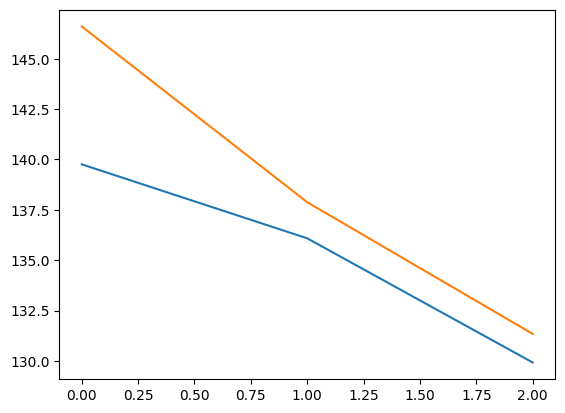

In [ ]:
plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])

# Testing

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
!mkdir outputs/

mkdir: cannot create directory ‘outputs/’: File exists


In [ ]:
COCO_PATH='/content/drive/MyDrive/Bang/coco_images/'

In [ ]:
def model_test(filename):
  try:
    test_path=COCO_PATH+filename

    print(test_path)

    img=cv2.resize(cv2.imread(test_path),(H,W))

    image=tf.io.decode_jpeg(tf.io.read_file(test_path))
    image=tf.image.resize(image, [H,W])

    output=model.predict(np.expand_dims(image, axis = 0))

    THRESH=.25

    object_positions=tf.concat(
        [tf.where(output[...,0]>=THRESH),tf.where(output[...,5]>=THRESH)],axis=0)
    print(object_positions)
    selected_output=tf.gather_nd(output,object_positions)
    print(selected_output)
    final_boxes=[]
    final_scores=[]

    for i,pos in enumerate(object_positions):
      for j in range(2):
        if selected_output[i][j*5]>THRESH:
          output_box=tf.cast(output[pos[0]][pos[1]][pos[2]][(j*5)+1:(j*5)+5],dtype=tf.float32)

          x_centre=(tf.cast(pos[1],dtype=tf.float32)+output_box[0])*32
          y_centre=(tf.cast(pos[2],dtype=tf.float32)+output_box[1])*32

          x_width,y_height=tf.math.abs(H*output_box[2]),tf.math.abs(W*output_box[3])

          x_min,y_min=int(x_centre-(x_width/2)),int(y_centre-(y_height/2))
          x_max,y_max=int(x_centre+(x_width/2)),int(y_centre+(y_height/2))

          if(x_min<=0):x_min=0
          if(y_min<=0):y_min=0
          if(x_max>=W):x_max=W
          if(y_max>=H):y_max=H
          final_boxes.append(
              [x_min,y_min,x_max,y_max,
              str(classes[tf.argmax(selected_output[...,10:],axis=-1)[i]])])
          final_scores.append(selected_output[i][j*5])
    print(final_scores)
    print('finalboxes',final_boxes)
    final_boxes=np.array(final_boxes)

    object_classes=final_boxes[...,4]
    nms_boxes=final_boxes[...,0:4]

    nms_output=tf.image.non_max_suppression(
        nms_boxes,final_scores,max_output_size=100,iou_threshold=0.2,
        score_threshold=float('-inf')
    )
    print(nms_output)

    for i in nms_output:
      cv2.rectangle(
          img,
          (int(final_boxes[i][0]),int(final_boxes[i][1])),
          (int(final_boxes[i][2]),int(final_boxes[i][3])),(0,0,255),1)
      cv2.putText(
          img,
          final_boxes[i][-1],
          (int(final_boxes[i][0]),int(final_boxes[i][1])+15),
          cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(2,225,155),1
          )

    cv2.imwrite('/content/outputs/'+filename[:-4]+'_det'+'.jpg',cv2.resize(img,(384,384)))
  except:
    print("NO object found !!!")

In [ ]:
for filename in os.listdir(COCO_PATH):
  model_test(filename)

/content/drive/MyDrive/Bang/coco_images/2007_000027.jpg
1/1 [==============================] - 0s 369ms/step
tf.Tensor(
[[0 3 3]
 [0 3 2]
 [0 3 3]], shape=(3, 3), dtype=int64)
tf.Tensor(
[[7.9928541e-01 5.9200025e-01 2.0390591e-01 4.8625043e-01 5.0782430e-01
  5.5228108e-01 6.3381851e-01 1.7156568e-01 2.1916898e-01 4.6306974e-01
  8.4404706e-04 1.2972140e-03 4.8355879e-03 2.0323358e-03 4.0734522e-03
  1.2075509e-03 3.2014821e-03 5.9257699e-03 2.8425951e-03 6.6515487e-03
  1.8137100e-05 3.2928542e-03 1.5848662e-03 3.9788947e-02 9.0481162e-01
  2.4520037e-05 2.1181118e-03 1.5629178e-03 1.0105668e-04 1.4598311e-03]
 [2.1671188e-01 5.4985368e-01 6.7698210e-01 2.0174935e-01 2.7311021e-01
  6.9427878e-01 7.0723003e-01 8.3224028e-01 5.3202116e-01 5.2394670e-01
  2.0780258e-03 8.2709541e-04 1.1200374e-02 1.6208375e-03 1.0668428e-03
  7.6595363e-03 1.0537550e-02 9.0537760e-03 1.6239895e-04 2.5159740e-04
  4.3407079e-05 1.1944999e-02 2.8819649e-04 5.5938121e-03 7.9422092e-01
  3.9013778e-04 7.62

In [ ]:
model.save("yolo_model")

TypeError: ignored

In [ ]:
!pip install -U tf2onnx
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.2/451.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 29.7 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.1 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.1 MB/s eta 0:00:00


# Web Interface

In [ ]:
import tensorflow as tf # For Creating Neural Networks and working with tensors
import numpy as np # Mathemtical computation of numpy arrays
import cv2
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape, LeakyReLU) # For layers need in our model

In [ ]:
classes=['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable',
         'dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']
B=2
N_CLASSES=len(classes)
H,W =224,224
SPLIT_SIZE=H//32
N_EPOCHS=135
BATCH_SIZE=32

In [ ]:
NUM_FILTERS=512
OUTPUT_DIM=N_CLASSES+5*B

In [ ]:
#base_model = tf.keras.applications.resnet50.ResNet50(
base_model=tf.keras.applications.efficientnet.EfficientNetB1(
    weights='imagenet',
    input_shape=(H,W,3),
    include_top=False,
)
base_model.trainable=False

In [ ]:
model=tf.keras.Sequential([
  base_model,
  Conv2D(NUM_FILTERS,(3,3), padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  LeakyReLU(alpha=0.1),

  Flatten(),

  Dense(NUM_FILTERS,kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Dropout(0.5),

  Dense(SPLIT_SIZE*SPLIT_SIZE*OUTPUT_DIM,activation='sigmoid'),

  Reshape((SPLIT_SIZE,SPLIT_SIZE,OUTPUT_DIM)),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 7, 7, 1280)       6575239   
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 512)         5898752   
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 7, 512)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 512)         2359808   
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                        

In [ ]:
model.load_weights("/content/my_model.h5")

In [ ]:
def predict_with_image(pic):
  img=pic
  image=tf.image.resize(pic, [H,W])

  output=model.predict(np.expand_dims(image, axis = 0))

  THRESH=.25

  object_positions=tf.concat(
      [tf.where(output[...,0]>=THRESH),tf.where(output[...,5]>=THRESH)],axis=0)
  print(object_positions)
  selected_output=tf.gather_nd(output,object_positions)
  print(selected_output)
  final_boxes=[]
  final_scores=[]

  for i,pos in enumerate(object_positions):
    for j in range(2):
      if selected_output[i][j*5]>THRESH:
        output_box=tf.cast(output[pos[0]][pos[1]][pos[2]][(j*5)+1:(j*5)+5],dtype=tf.float32)

        x_centre=(tf.cast(pos[1],dtype=tf.float32)+output_box[0])*32
        y_centre=(tf.cast(pos[2],dtype=tf.float32)+output_box[1])*32

        x_width,y_height=tf.math.abs(H*output_box[2]),tf.math.abs(W*output_box[3])

        x_min,y_min=int(x_centre-(x_width/2)),int(y_centre-(y_height/2))
        x_max,y_max=int(x_centre+(x_width/2)),int(y_centre+(y_height/2))

        if(x_min<=0):x_min=0
        if(y_min<=0):y_min=0
        if(x_max>=W):x_max=W
        if(y_max>=H):y_max=H
        final_boxes.append(
            [x_min,y_min,x_max,y_max,
            str(classes[tf.argmax(selected_output[...,10:],axis=-1)[i]])])
        final_scores.append(selected_output[i][j*5])
  print(final_scores)
  print('finalboxes',final_boxes)
  final_boxes=np.array(final_boxes)

  object_classes=final_boxes[...,4]
  nms_boxes=final_boxes[...,0:4]

  nms_output=tf.image.non_max_suppression(
      nms_boxes,final_scores,max_output_size=100,iou_threshold=0.2,
      score_threshold=float('-inf')
  )
  print(nms_output)

  for i in nms_output:
    cv2.rectangle(
        img,
        (int(final_boxes[i][0]),int(final_boxes[i][1])),
        (int(final_boxes[i][2]),int(final_boxes[i][3])),(0,0,255),1)
    cv2.putText(
        img,
        final_boxes[i][-1],
        (int(final_boxes[i][0]),int(final_boxes[i][1])+15),
        cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(2,225,155),1
        )
  return cv2.resize(img,(384,384))

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

In [ ]:
image_input = gr.inputs.Image(shape=(224, 224))

<ipython-input-10-d2e43f7d2a3b>:1: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  image_input = gr.inputs.Image(shape=(224, 224))
<ipython-input-10-d2e43f7d2a3b>:1: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  image_input = gr.inputs.Image(shape=(224, 224))


In [ ]:
iface = gr.Interface(fn=predict_with_image, inputs=image_input, outputs="image", capture_session=True)

<ipython-input-11-7cacc0337ab8>:1: GradioDeprecationWarning: `capture_session` parameter is deprecated, and it has no effect
  iface = gr.Interface(fn=predict_with_image, inputs=image_input, outputs="image", capture_session=True)


In [ ]:
iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 3s 3s/step
tf.Tensor([[0 3 3]], shape=(1, 3), dtype=int64)
tf.Tensor(
[[9.49637055e-01 5.24526894e-01 4.18204218e-01 9.89299893e-01
  9.93113577e-01 2.43352324e-01 5.26462376e-01 3.80486459e-01
  7.17184007e-01 8.51296246e-01 5.84106238e-05 1.16644351e-05
  6.85088071e-06 3.60563397e-04 1.76570156e-05 1.32722111e-04
  1.65546135e-05 3.35295132e-04 1.86620036e-03 1.06853840e-03
  2.26842667e-06 8.40844528e-04 1.47332485e-05 5.61045454e-05
  9.97439861e-01 1.40416505e-05 4.36026516e-04 2.37669442e-02
  1.06990454e-04 1.84367469e-04]], shape=(1, 30), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.94963706>]
finalboxes [[1, 0, 223, 220, 'person']]
tf.Tensor([0], shape=(1,), dtype=int32)
Keyboard interruption in main thread... closing server.
